inspiration: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [2]:
import os
import random
import numpy as np

os.environ["CUDA_VISIBLE_DEVICES"]='1'
import tensorflow as tf
from matplotlib import pyplot as plt

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout
from keras import Sequential, Input

In [3]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences/'

sequences = []

labels = None
no_labels = None

no_features: int = None

count = 0
for file_name in os.listdir(data_directory):
    count += 1
    if count % 50000 == 0:
        print(f'Loaded {count} sequences')
    #if count > 50000:
    #    break
    with open(data_directory + file_name, 'r') as f:
        label = file_name.split('_')[0]
        data = f.readlines(1000)
        data = [ x.strip() for x in data ]
        sequences.append((label, data))

print(f'Loaded {len(sequences)} sequences')

random.shuffle(sequences)
labels = [ x[0] for x in sequences ]
sequences = [ x[1] for x in sequences ]

distinct_labels = np.unique(np.array(labels))
no_labels = len(distinct_labels)
print(f'Found {no_labels} distinct labels')

distinct_features = np.unique(np.array([ x for sequence in sequences for x in sequence ]))
#distinct_features = np.append(distinct_features, 'NONE')
no_features = len(distinct_features)
print(f'Found {no_features} distinct features')

# encode labels from strings to integers to one-hot
labels = np.eye(no_labels)[np.vectorize(distinct_labels.tolist().index)(labels)]
print(f'Encoded labels to one-hot')

# encode features from strings to integers
sequences = [ [ distinct_features.tolist().index(x) for x in sequence ] for sequence in sequences ]
print(f'Encoded features to integers')
# encode features from integers to one-hot
sequences = [ np.eye(no_features)[sequence] for sequence in sequences ]
print(f'Encoded features to one-hot')

# get pad event to pad sequences with when batches are built
pad_event = np.zeros(no_features)

Loaded 50000 sequences
Loaded 100000 sequences
Loaded 150000 sequences
Loaded 200000 sequences
Loaded 250000 sequences
Loaded 300000 sequences
Loaded 350000 sequences
Loaded 400000 sequences
Loaded 430863 sequences
Found 135 distinct labels
Found 29 distinct features
Encoded labels to one-hot
Encoded features to integers
Encoded features to one-hot


In [4]:
model = Sequential(layers=[
    Input(shape=(None, no_features)),
    SimpleRNN(64, recurrent_dropout=0.1, return_sequences=True),
    Dropout(0.1),
    SimpleRNN(64, recurrent_dropout=0.1, return_sequences=True),
    Dropout(0.1),
    SimpleRNN(64, recurrent_dropout=0, return_sequences=False),
    Dense(no_labels, activation='softmax'),
])

model.summary()

2024-06-12 15:45:12.471420: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9504 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 64)       │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 135)            │         8,775 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,303 (122.28 KB)

 Trainable params: 31,303 (122.28 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    mode='auto'
)

checkpoint_path = ("/home/jrosendahl/sync/models/checkpoints")
model_checkpoint = ModelCheckpoint(
    filepath=f'{checkpoint_path}/rnn_generator.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.1, 
    patience=3, 
    min_lr=1e-6
)
# 'categorical_focal_crossentropy'
# 'categorical_crossentropy'
model.compile(optimizer='adam', loss='categorical_focal_crossentropy', metrics=['accuracy'])

In [ ]:
X_train = sequences[:int(len(sequences) * 0.8)]
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post')
y_train = labels[:int(len(sequences) * 0.8)]

X_val = sequences[int(len(sequences) * 0.8):]
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, padding='post')
y_val = labels[int(len(sequences) * 0.8):]

In [7]:
# load model if it exists
if os.path.exists(f'{checkpoint_path}/rnn_generator.keras'):
    model.load_weights(f'{checkpoint_path}/rnn_generator.keras')
    print('Loaded model')

Loaded model


In [8]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    callbacks=[early_stop, model_checkpoint, lr_schedule],
)

2024-06-12 16:35:24.170650: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8036792040 exceeds 10% of free system memory.


Epoch 1/15
10772/10772 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5312 - loss: 0.3345
Epoch 1: val_loss did not improve from 0.33168
10772/10772 ━━━━━━━━━━━━━━━━━━━━ 549s 51ms/step - accuracy: 0.5312 - loss: 0.3345 - val_accuracy: 0.3993 - val_loss: 0.4392 - learning_rate: 0.0010
Epoch 2/15
 9462/10772 ━━━━━━━━━━━━━━━━━━━━ 1:00 46ms/step - accuracy: 0.3953 - loss: 0.4372

KeyboardInterrupt: 

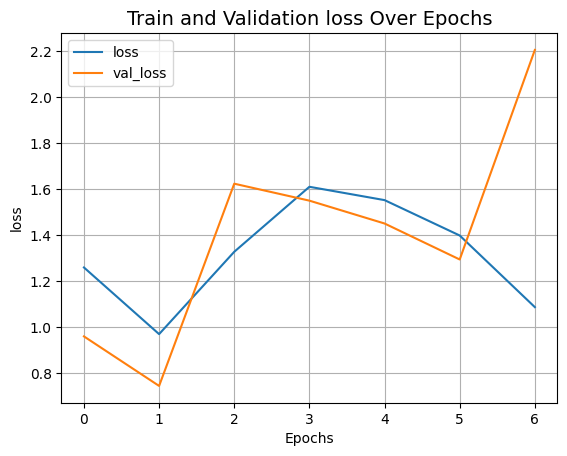

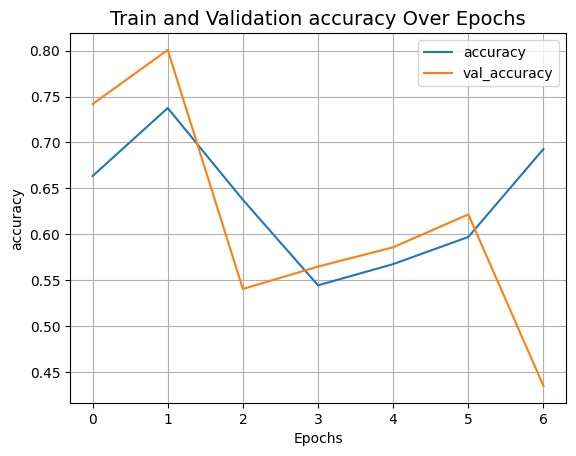

2693/2693 ━━━━━━━━━━━━━━━━━━━━ 60s 22ms/step - accuracy: 0.4332 - loss: 2.2149


[2.2053439617156982, 0.43476495146751404]

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

# evaluage model
X_test = sequences[int(len(sequences) * 0.8):]
# pad
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post')

y_test = labels[int(len(sequences) * 0.8):]

model.evaluate(X_test, y_test)


padding aendern, nicht auf laengstes, sondern laengstes abschneiden

weight decay fuers training


In [ ]:
# predict on test data and evaluate
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(np.array(y_test), axis=1)

from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

2693/2693 ━━━━━━━━━━━━━━━━━━━━ 47s 17ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        26
           2       0.00      0.00      0.00       241
           3       0.00      0.00      0.00       180
           4       0.00      0.00      0.00       579
           5       0.00      0.00      0.00         8
           7       0.91      0.97      0.94     32054
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00        79
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00       239
          16       0.00      0.00      0.00        10
          17       0.00      0.00      0.00         2
          18       0.99      0.65   

/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap